In [89]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 29 21:06:55 2018

@author: paulhuynh
"""

###############################################################################
### packages required to run code.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np


In [90]:
###############################################################################
### Function to process documents
###############################################################################
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    #remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    #filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    #filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    #word stemming    
#     ps=PorterStemmer()
#     tokens=[ps.stem(word) for word in tokens]
    return tokens

###############################################################################
#   Functions to label encoding
###############################################################################
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

###############################################################################

In [91]:
### Processing text into lists
###############################################################################

#read in class corpus csv into python
data=pd.read_csv('Corpus.csv')

#create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

#Note: the text_body is the unprocessed list of documents read directly from 
#the csv.
    
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.
#Note: the list of words is separated by commas.


#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

#final section of code has 3 lists used.  2 of which are used for further processing.
#(1) text_body - unused, (2) processed_text (used in W2V), 
#(3) final_processed_text (used in TFIDF), and (4) DSI titles (used in TFIDF Matrix)
 

In [92]:
###############################################################################
### Sklearn TFIDF 
###############################################################################

#call Tfidf Vectorizer
Tfidf=TfidfVectorizer()

#fit the vectorizer using final processed documents. 
#the vectorizer requires the stiched back together document.

TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)


Text(0, 0.5, 'Inertia')

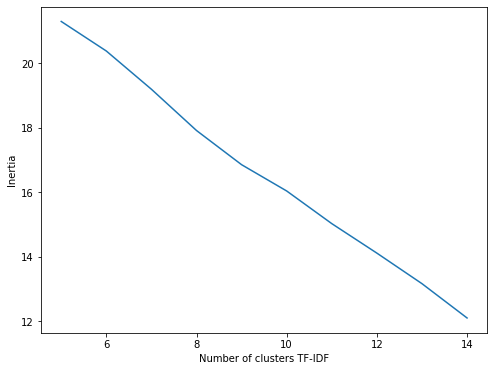

In [93]:
### The Elbow Method - TF-IDF

#k-Means is applied with a different number of clusters while recording the sum of squared errors. 

sse = []
for k in range(5,15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(matrix)
    sse.append(kmeans.inertia_)

    
#you can then create a `dataFrame` containing the clusters and the accompanying error. 
cluster_df = pd.DataFrame({'Cluster':range(5,15), 'sse':sse})
cluster_df.head()


#plot these errors and identify the elbow point. 
#this the point at which the curve starts to bend. 
plt.figure(figsize=(8,6))
plt.plot(cluster_df['Cluster'], cluster_df['sse'])
plt.xlabel('Number of clusters TF-IDF')
plt.ylabel('Inertia')

In [94]:
###############################################################################
### Gensim Word2vec 
###############################################################################

#word to vec
model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)


#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

Text(0, 0.5, 'Inertia')

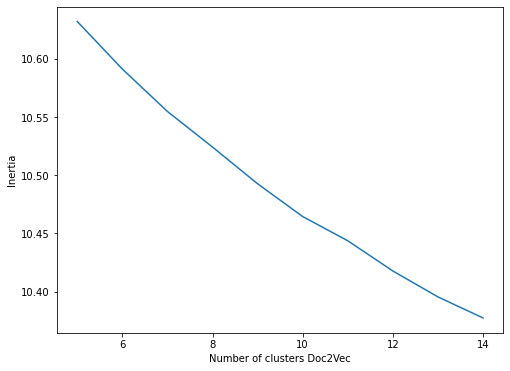

In [95]:
### The Elbow Method - Doc2Vec

#k-Means is applied with a different number of clusters while recording the sum of squared errors.

sse = []
for k in range(5,15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(w2v_df)
    sse.append(kmeans.inertia_)
    
cluster_df = pd.DataFrame({'Cluster':range(5,15), 'sse':sse})
cluster_df.head()

plt.figure(figsize=(8,6))
plt.plot(cluster_df['Cluster'], cluster_df['sse'])
plt.xlabel('Number of clusters Doc2Vec')
plt.ylabel('Inertia')

In [96]:
###############################################################################
### Doc2Vec
###############################################################################
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)



In [97]:
###############################################################################
### K Means Clustering Doc2Vec
###############################################################################
doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=8
km = KMeans(n_clusters=k, random_state=89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store terms and titles
cluster_title={}

for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list
        


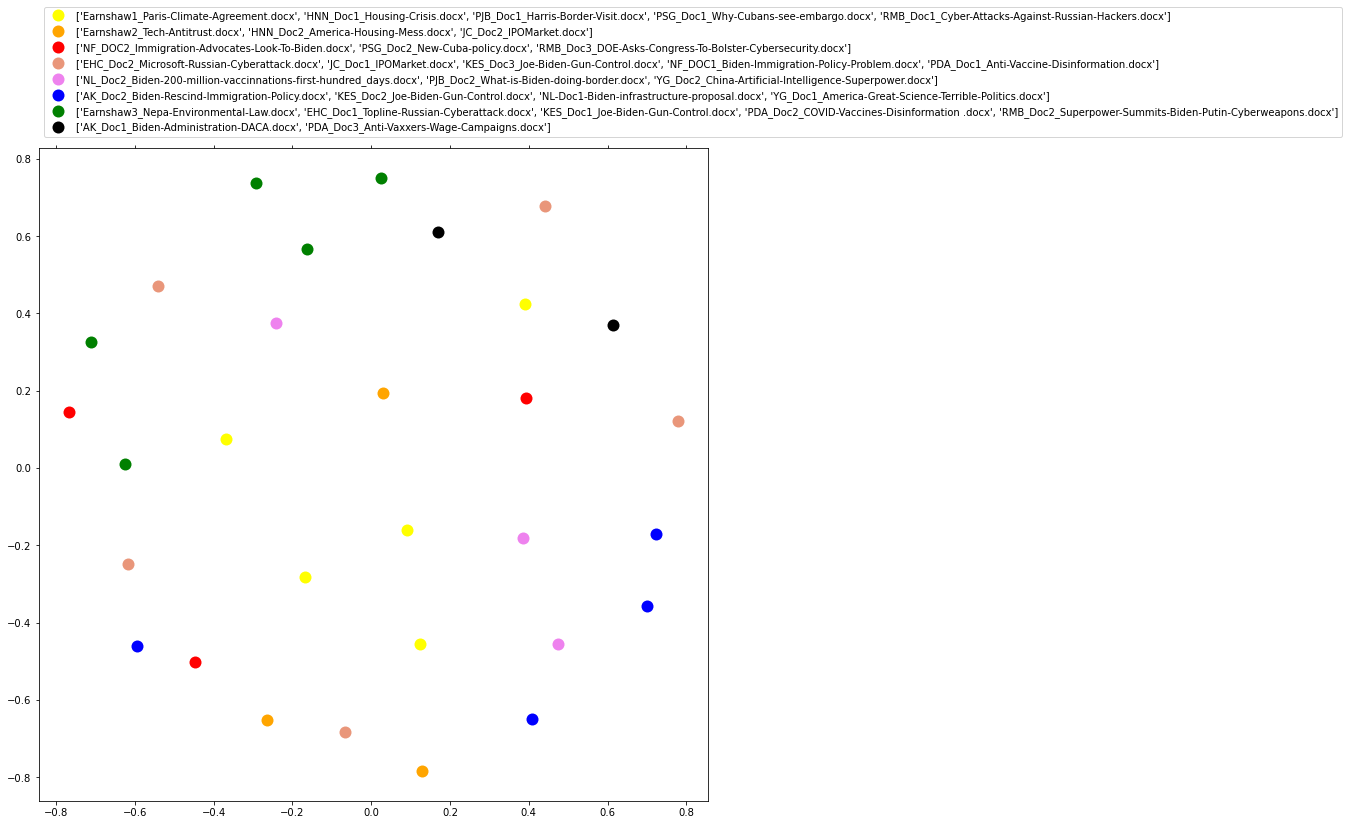

In [98]:
###############################################################################
### Plotting Doc2vec
###############################################################################
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.


mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'yellow', 1: 'orange', 2: 'red', 3: 'darksalmon', 4: 'violet', 
                  5:'blue', 6:'green', 7:'black'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters_d2v, title=range(0,len(clusters_d2v))))

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='lower left', bbox_to_anchor=(0.0, 1.01))      #show legend with only 1 point

In [109]:
###############################################################################
### Performance Metrics Doc2Vec
###############################################################################

from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(clusters_d2v, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(clusters_d2v, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(doc2vec_k_means, km.labels_, sample_size=30))

#source code: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

Homogeneity: 0.384
Completeness: 0.390
Silhouette Coefficient: -0.041


In [100]:
###############################################################################
### K-Means Clustering TF-IDF
###############################################################################
k=8
km = KMeans(n_clusters=k, random_state=89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid Clus
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 border
 immigration
 harris
 biden
 children
 democrats
 migrants
 asylum
 voters
 trump
Cluster 0 titles: AK_Doc2_Biden-Rescind-Immigration-Policy.docx, NF_DOC1_Biden-Immigration-Policy-Problem.docx, NF_DOC2_Immigration-Advocates-Look-To-Biden.docx, PJB_Doc1_Harris-Border-Visit.docx, PJB_Doc2_What-is-Biden-doing-border.docx,Cluster 1:
 antitrust
 federal
 violence
 biden
 regulations
 environmental
 administration
 dealers
 would
 firearms
Cluster 1 titles: AK_Doc1_Biden-Administration-DACA.docx, Earnshaw2_Tech-Antitrust.docx, Earnshaw3_Nepa-Environmental-Law.docx, KES_Doc1_Joe-Biden-Gun-Control.docx, KES_Doc2_Joe-Biden-Gun-Control.docx, KES_Doc3_Joe-Biden-Gun-Control.docx,Cluster 2:
 russia
 attacks
 russian
 ransomware
 hackers
 attack
 cyber
 putin
 cybersecurity
 microsoft
Cluster 2 titles: EHC_Doc1_Topline-Russian-Cyberattack.docx, EHC_Doc2_Microsoft-Russian-Cyberattack.docx, RMB_Doc1_Cyber-Attacks-Against-Russian-Hackers.docx, RMB_Doc2_Superpow

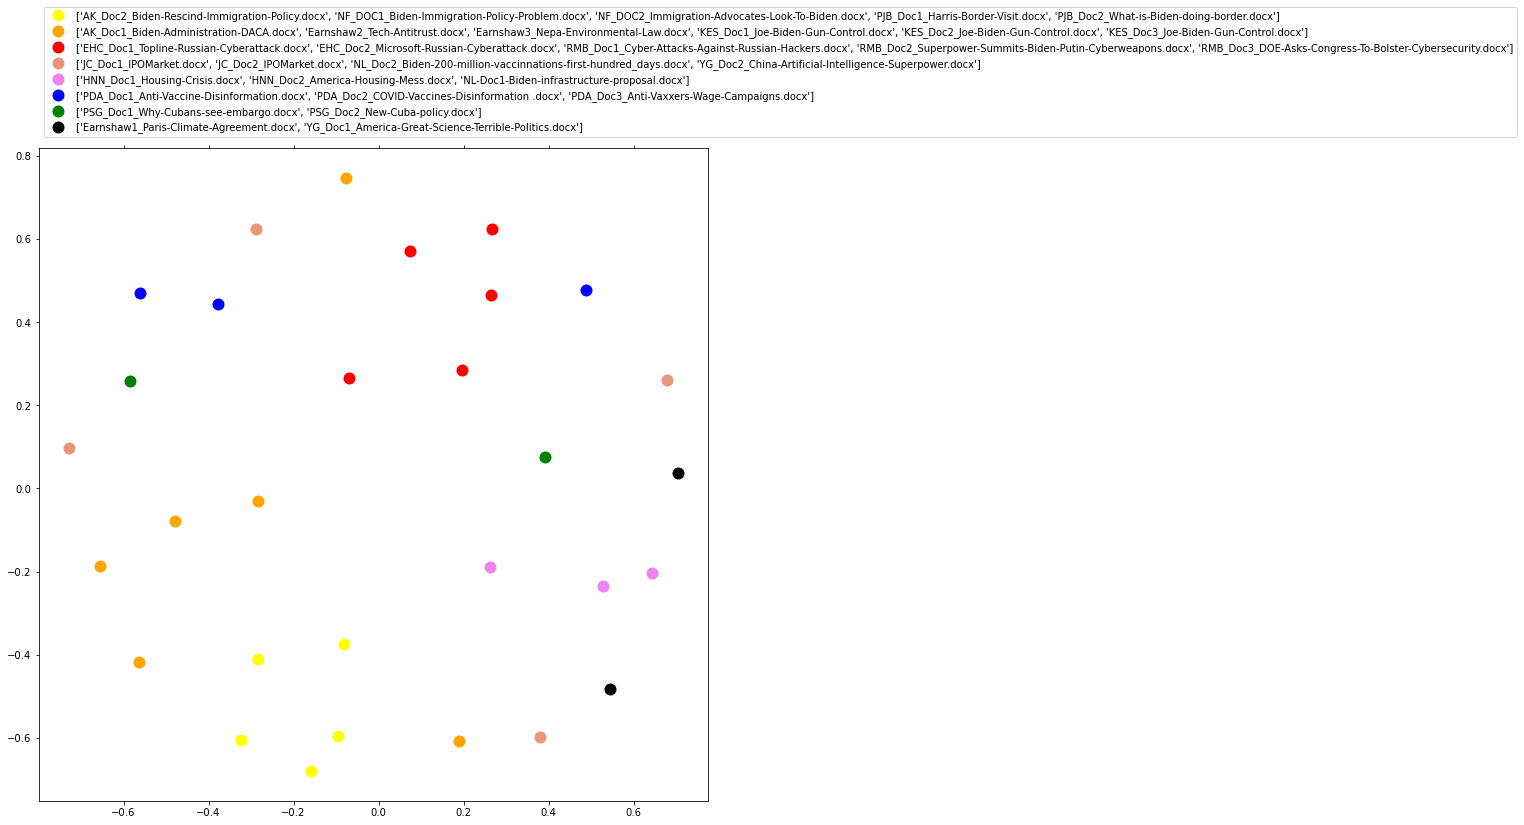

In [101]:
###############################################################################
### Plotting
###############################################################################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.


mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'yellow', 1: 'orange', 2: 'red', 3: 'darksalmon', 4: 'violet', 
                  5:'blue', 6:'green', 7:'black'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='lower left', bbox_to_anchor=(0.0, 1.01))      #show legend with only 1 point


In [108]:
###############################################################################
### Performance Metrics TF-IDF
###############################################################################

from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(clusters, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(clusters, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(TFIDF_matrix, km.labels_, sample_size=30))

#source code: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

Homogeneity: 1.000
Completeness: 1.000
Silhouette Coefficient: 0.069
